In [1]:
setwd('/Volumes/Dominik/Documents/snotel-regression_project')
# setwd('~/Documents/snotel-regression_project')
library(raster)
library(reshape2)
library(plyr)
library(ggplot2)
library(doMC)
library(RColorBrewer)

Loading required package: sp
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [2]:
rswe='v3.1'
covrange='idp1'
fscaMatch='wofsca'
scalesnotel='scale'
cost='r2'
dateflag='surveyvalidation'
blending='unblended'
style='real-time'
gridding=''#_snodasgrid'
postscaled=''#_postscaled'

In [3]:
swe=readRDS(file=paste0('data/spatialvalidation/',blending,'/',dateflag,'/',style,'/surveygriddedswe',gridding,'_rswe',rswe,'_',covrange,'_snotel',scalesnotel,postscaled,'_',cost,'_',fscaMatch,'.rds'))
swe_all=swe
cellcount=ddply(swe_all,.(model.type),function(dF) count(dF$cell))
freqdf=dcast(cellcount,model.type~x,value.var='freq')
ind=which(freqdf[1,2:ncol(freqdf)]<140)#about 278 30m cells in an 500m pixel #rows 1,2,3 will be the same
cell2rm=as.numeric(colnames(freqdf)[-1][ind])
ind2=which(freqdf[nrow(freqdf),2:ncol(freqdf)]<560)#about 1111 30m cells in 1km pixel #last row is snodas
cell2rm2=as.numeric(colnames(freqdf)[-1][ind2])
swe=subset(swe_all,(model.type!='SNODAS' & !(cell %in% cell2rm)) | (model.type=='SNODAS' & !(cell %in% cell2rm2)))
swe$swe.model[swe$swe.model<0.001]=0

In [4]:
## define cost function
docost=function(y,yhat,cost){
if(cost=='mae') { #statistics to minimize
          costfun<-function(y, yhat) mean(abs(yhat-y),na.rm=T)
} else if(cost=='rmse') {
          costfun<-function(y,yhat) sqrt(mean((yhat-y)^2,na.rm=T))
} else if (cost=='relrmse'){
          costfun<-function(y,yhat) sqrt(mean((yhat-y)^2,na.rm=T))/mean(y,na.rm=T)
} else if (cost=='bias'){
          costfun<-function(y,yhat) mean(yhat-y,na.rm=T)
} else if (cost=='pctbias'){
              costfun<-function(y,yhat) mean(yhat-y,na.rm=T)/mean(y,na.rm=T)*100
          }
              
     costfun(y,yhat)
}

# Average observations within model cell

In [5]:
cellavg=ddply(swe,.(model.type,date,site,yr,mth,cell),function(dF){ 
    summarise(dF,
            swe.obs.avg=mean(swe.obs,na.rm=T),#the cell number in swe represents the model cell number so there can be muliple obs cell values (30m)
                                        # na.rm=F will average only for model pixels that are completely covered by observations, otherwise there can be overlap
              swe.model=unique(swe.model))# there should only be one value for each cell
    })

# Green Lakes Valley

## average rmse

In [55]:
glvswe=subset(cellavg,site=='Green Lakes Valley')
# glvswe
objf='rmse'
objcost=ddply(glvswe,.(model.type,date,site,yr,mth),function(dF){
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overallrmse=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overallrmse)[ncol(overallrmse)]=objf
overallrmse

,model.type,rmse
1,PHV,0.4720757
2,PHVRCN,0.4397443
3,RCN,0.4950087
4,SNODAS,0.612666


## freq best model type

In [74]:
# dcast(objcost,date+site+yr+mth~model.type,value.var='cost')
cost.df=dcast(subset(objcost,model.type=='PHV' | model.type=='PHVRCN'),model.type+site+date~.,value.var='cost')
colnames(cost.df)=c('model.type','site','date','avg_cost')
cost.df
bestcost=ddply(cost.df,.(site,date),function(dF){
  as.character(dF$model.type[which.min(dF$avg_cost)])
})
# bestcost
# tmpdf=cost.df[c(1,8),]
#   as.character(tmpdf$model.type[which.min(tmpdf$avg_cost)])
count(bestcost$V1)

,model.type,site,date,avg_cost
1,PHV,Green Lakes Valley,2001-05-09,0.2775448
2,PHV,Green Lakes Valley,2002-05-01,0.2087712
3,PHV,Green Lakes Valley,2003-05-14,0.3189109
4,PHV,Green Lakes Valley,2004-05-12,0.3219831
5,PHV,Green Lakes Valley,2005-05-10,0.1734238
6,PHV,Green Lakes Valley,2006-05-11,0.1922925
7,PHV,Green Lakes Valley,2007-05-10,0.2465059
8,PHVRCN,Green Lakes Valley,2001-05-09,0.1303036
9,PHVRCN,Green Lakes Valley,2002-05-01,0.2283391
10,PHVRCN,Green Lakes Valley,2003-05-14,0.1927775


,x,freq
1,PHV,3
2,PHVRCN,4


### freq with snodas

In [75]:
# dcast(objcost,date+site+yr+mth~model.type,value.var='cost')
cost.df=dcast(subset(objcost,yr>2003),model.type+site+date~.,value.var='cost')
colnames(cost.df)=c('model.type','site','date','avg_cost')
cost.df
bestcost=ddply(cost.df,.(site,date),function(dF){
  as.character(dF$model.type[which.min(dF$avg_cost)])
})
bestcost
count(bestcost$V1)

,model.type,site,date,avg_cost
1,PHV,Green Lakes Valley,2004-05-12,0.3219831
2,PHV,Green Lakes Valley,2005-05-10,0.1734238
3,PHV,Green Lakes Valley,2006-05-11,0.1922925
4,PHV,Green Lakes Valley,2007-05-10,0.2465059
5,PHVRCN,Green Lakes Valley,2004-05-12,0.1427303
6,PHVRCN,Green Lakes Valley,2005-05-10,0.4380337
7,PHVRCN,Green Lakes Valley,2006-05-11,0.5031636
8,PHVRCN,Green Lakes Valley,2007-05-10,0.2368652
9,RCN,Green Lakes Valley,2004-05-12,0.3447479
10,RCN,Green Lakes Valley,2005-05-10,0.5015789


,site,date,V1
1,Green Lakes Valley,2004-05-12,PHVRCN
2,Green Lakes Valley,2005-05-10,PHV
3,Green Lakes Valley,2006-05-11,PHV
4,Green Lakes Valley,2007-05-10,PHVRCN


,x,freq
1,PHV,2
2,PHVRCN,2


## average relative rmse

In [76]:
glvswe=subset(cellavg,site=='Green Lakes Valley')
objf='relrmse'
objcost=ddply(glvswe,.(model.type,date,site,yr,mth),function(dF){
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overallrmse=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overallrmse)[ncol(overallrmse)]=objf
overallrmse

,model.type,relrmse
1,PHV,0.3589191
2,PHVRCN,0.3849019
3,RCN,0.6002207
4,SNODAS,NaN


In [77]:
objf='pctbias'
glvswe=subset(cellavg,site=='Green Lakes Valley')
objcost=ddply(glvswe,.(model.type,date,site,yr,mth),function(dF){ 
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overall=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overall)[ncol(overall)]=objf
overall

,model.type,pctbias
1,PHV,-25.75625
2,PHVRCN,31.69098
3,RCN,-37.53135
4,SNODAS,NaN


# Forested Surveys

## average rmse

In [56]:
forestswe=subset(cellavg,site!='Green Lakes Valley')
objf='rmse'
objcost=ddply(forestswe,.(model.type,date,site,yr,mth),function(dF){
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overallrmse=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overallrmse)[ncol(overallrmse)]=objf
overallrmse

,model.type,rmse
1,PHV,0.1851321
2,PHVRCN,0.1671354
3,RCN,0.2674632
4,SNODAS,0.1252745


In [7]:
forestswe=subset(cellavg,site!='Green Lakes Valley')
# forestswe=subset(cellavg,site=='Niwot' | site=='Green Lakes Valley' | site=='Dry Lake' | site=='Joe Wright' | site=='South Brush Creek')
objf='relrmse'
objcost=ddply(forestswe,.(model.type,date,site,yr,mth),function(dF){
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overallrmse=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overallrmse)[ncol(overallrmse)]=objf
overallrmse

,model.type,relrmse
1,PHV,0.554398
2,PHVRCN,0.5130659
3,RCN,0.7400316
4,SNODAS,0.323514


## freq best model type

In [8]:
cost.df=dcast(subset(objcost,model.type=='PHV' | model.type=='PHVRCN'),model.type+site+date~.,value.var='cost')
colnames(cost.df)=c('model.type','site','date','avg_cost')
bestcost=ddply(cost.df,.(site,date),function(dF){
  as.character(dF$model.type[which.min(dF$avg_cost)])
})
# bestcost
count(bestcost$V1)

,x,freq
1,PHV,8
2,PHVRCN,14


In [9]:
objf='pctbias'
forestswe=subset(cellavg,site!='Green Lakes Valley')
forestswe=subset(cellavg,site=='Niwot' | site=='Green Lakes Valley' | site=='Dry Lake' | site=='Joe Wright' | site=='South Brush Creek')
objcost=ddply(forestswe,.(model.type,date,site,yr,mth),function(dF){ 
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overall=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overall)[ncol(overall)]=objf
overall

,model.type,pctbias
1,PHV,-6.395795
2,PHVRCN,4.420913
3,RCN,-41.12108
4,SNODAS,-15.44504


# All sites

## average rmse

In [57]:
objf='rmse'
objcost=ddply(cellavg,.(model.type,date,site,yr,mth),function(dF){  
    cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
    data.frame(cost)
})
# objcost
overallrmse=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overallrmse)[ncol(overallrmse)]=objf
overallrmse
# write.table(format(overallrmse,digits=1,trim=F,nsmall=2),paste0('graphs/rswe_',rswe,'/covrange',covrange,'/snotel',scalesnotel,'/',dateflag,'/',fscaMatch,'/boxplot_overallrmse_',blending,'models_vs_griddedobs_facet-datesite_',cost,'-rcnselect.txt'),sep='\t',row.names=F,quote=F)

,model.type,rmse
1,PHV,0.2543944
2,PHVRCN,0.2329376
3,RCN,0.3264565
4,SNODAS,0.2335837


## freq best model type

In [11]:
cost.df=dcast(subset(objcost,model.type=='PHV' | model.type=='PHVRCN'),model.type+site+date~.,value.var='cost')
colnames(cost.df)=c('model.type','site','date','avg_cost')
# cost.df
bestcost=ddply(cost.df,.(site,date),function(dF){
  as.character(dF$model.type[which.min(dF$avg_cost)])
})
# bestcost
count(bestcost$V1)

,x,freq
1,PHV,10
2,PHVRCN,19


## freq with snodas

In [12]:
cost.df=dcast(subset(objcost,yr>2003),model.type+site+date~.,value.var='cost')
colnames(cost.df)=c('model.type','site','date','avg_cost')
#cost.df
bestcost=ddply(cost.df,.(site,date),function(dF){
  as.character(dF$model.type[which.min(dF$avg_cost)])
})
# bestcost
count(bestcost$V1)

,x,freq
1,PHV,4
2,PHVRCN,5
3,RCN,1
4,SNODAS,8


*** why is relrmse for snodas lower than phv and phvrcn... should be similarly scaled?

In [13]:
objf='relrmse'
objcost=ddply(cellavg,.(model.type,date,site,yr,mth),function(dF){
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overallrmse=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overallrmse)[ncol(overallrmse)]=objf
overallrmse
#write.table(format(overallrmse,digits=1,trim=F,nsmall=2),paste0('graphs/rswe_',rswe,'/covrange',covrange,'/snotel',scalesnotel,'/',dateflag,'/',fscaMatch,'/boxplot_overallrmse_',blending,'models_vs_griddedobs_facet-datesite_',cost,'-rcnselect.txt'),sep='\t',row.names=F,quote=F)

,model.type,relrmse
1,PHV,0.5737897
2,PHVRCN,0.5221732
3,RCN,0.7190169
4,SNODAS,0.4396692


In [14]:
objf='bias'
objcost=ddply(cellavg,.(model.type,date,site,yr,mth),function(dF){ 
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
overall=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
# dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overall)[ncol(overall)]=objf
overall


,model.type,bias
1,PHV,-0.1089088
2,PHVRCN,-0.03711871
3,RCN,-0.2500732
4,SNODAS,-0.1202049


### percent bias

In [17]:
objf='pctbias'
objcost=ddply(cellavg,.(model.type,date,site,yr,mth),function(dF){ 
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
dcast(objcost,date+site~model.type,value.var='cost')

,date,site,PHV,PHVRCN,RCN,SNODAS
1,2001-04-22,Slumgullion,38.97161,25.31923,-74.87865,NaN
2,2001-04-23,Upper San Juan,-57.65358,-55.02342,-63.28773,NaN
3,2001-04-24,Wolf Creek Summit,-56.9814,-55.73043,-64.83091,NaN
4,2001-04-27,Lilly Pond,1.479039,-11.18001,-70.57077,NaN
5,2001-05-09,Green Lakes Valley,-37.6953,-12.56368,-32.83079,NaN
6,2002-04-03,Lilly Pond,29.53353,4.811711,-65.62258,NaN
7,2002-04-04,Wolf Creek Summit,-19.56923,-4.351162,-91.71872,NaN
8,2002-04-05,Upper San Juan,-17.06929,1.146475,-94.58599,NaN
9,2002-04-06,Slumgullion,82.18698,65.28052,-71.25581,NaN
10,2002-05-01,Green Lakes Valley,-51.39466,-5.24698,-41.40114,NaN


In [15]:
overall=dcast(objcost,model.type~.,fun.aggregate=mean,na.rm=T,value.var='cost')
colnames(overall)[ncol(overall)]=objf
overall

,model.type,pctbias
1,PHV,-5.536962
2,PHVRCN,0.7894859
3,RCN,-52.55024
4,SNODAS,-13.83752


# How does scale bias of SNOTEL affect regression at surveys?

In [40]:
dcast(objcost,yr+mth~model.type,value.var='cost',fun.agg=mean,na.rm=T)
# phv=c(-1,32,33,3)
# phvrcn=c(-7,25,24,-5)
# snotel=c(17,65,-3,23)
# cor(phv,snotel,method='spearman')
# cor(phvrcn,snotel,method='spearman')
dcast(objcost,site+date~model.type,value.var='cost')

,yr,mth,PHV,PHVRCN,RCN,SNODAS
1,2001,04,-7.876811,-14.36858,-68.64356,NaN
2,2001,05,-27.70878,6.705067,-22.63572,NaN
3,2002,04,67.13142,50.93984,-84.53579,NaN
4,2002,05,-30.95311,80.2319,-43.10828,NaN
5,2003,05,-32.59926,30.58215,-19.24805,NaN
6,2004,05,-46.16943,8.195837,-36.75106,NaN
7,2005,05,-7.919456,46.9134,-26.00171,NaN
8,2006,05,-7.108841,110.735,-55.598,NaN
9,2007,05,-27.83453,25.10015,-59.37663,NaN
10,2008,03,-25.28541,-26.32497,-83.77556,15.02406


,site,date,PHV,PHVRCN,RCN,SNODAS
1,Dry Lake,2008-04-04,-13.17655,-4.686605,-31.52885,10.38535
2,Dry Lake,2008-05-02,-36.25686,-11.83329,-45.8427,-23.85934
3,Dry Lake,2009-02-28,-25.09753,-4.902132,NaN,-19.5697
4,Dry Lake,2009-03-28,-23.07472,-18.67145,-41.19789,-31.24869
5,Green Lakes Valley,2001-05-09,-27.70878,6.705067,-22.63572,NaN
6,Green Lakes Valley,2002-05-01,-30.95311,80.2319,-43.10828,NaN
7,Green Lakes Valley,2003-05-14,-32.59926,30.58215,-19.24805,NaN
8,Green Lakes Valley,2004-05-12,-46.16943,8.195837,-36.75106,NaN
9,Green Lakes Valley,2005-05-10,-7.919456,46.9134,-26.00171,NaN
10,Green Lakes Valley,2006-05-11,-7.108841,110.735,-55.598,NaN


### avg pct bias at other snotel surveys the same week as each survey

In [59]:
#leave out survey station for mean bias because survey station wasn't used in regression
weeklysurveyavg=ddply(objcost,.(model.type,yr,mth),function(dF){
#print(dF)
#     str(dF)
    dFo=data.frame()
    for(s in unique(dF$site)){
  #      print(s)
        sid=which(dF$site==s)
 #       str(sid)
       # str(dF$cost)
        avg=mean(dF$cost[-sid],na.rm=T)
#          print(avg)
        dFo=rbind(dFo,data.frame(site=s,date=dF$date[sid],avg))
        }
#    print(dFo)
    return(dFo)
})
dcast(weeklysurveyavg,site+date~model.type,value.var='avg')
# weekavg=dcast(weeklysurveyavg,site+date+yr+mth~model.type,value.var='avg',fun.agg=mean,na.rm=T)
# weekavg$pattern=c(rep('a',15),'a1','a','m','ac','m','a','m','ac','m','a','m','a','m','ac')
# mean(weekavg$PHV-weekavg$PHVRCN,na.rm=T)
# data.frame(mean(weekavg$PHV,na.rm=T),mean(weekavg$PHVRCN,na.rm=T))
# weekavg 

,site,date,PHV,PHVRCN,RCN,SNODAS
1,Slumgullion,2001-04-22,-36.9415,-39.96884,-66.58966,NaN
2,Slumgullion,2002-04-06,-4.294667,-1.288593,-89.48298,NaN
3,Upper San Juan,2001-04-23,-4.702842,-13.15699,-70.26045,NaN
4,Upper San Juan,2002-04-05,31.56377,22.55747,-81.11455,NaN
5,Wolf Creek Summit,2001-04-24,-4.866326,-12.86519,-69.58805,NaN
6,Wolf Creek Summit,2002-04-04,31.23915,23.00495,-82.46157,NaN
7,Lilly Pond,2001-04-27,-25.34167,-28.59833,-68.1361,NaN
8,Lilly Pond,2002-04-03,17.85057,22.65651,-85.08405,NaN
9,Green Lakes Valley,2001-05-09,NaN,NaN,NaN,NaN
10,Green Lakes Valley,2002-05-01,NaN,NaN,NaN,NaN


In [60]:
dcast(weeklysurveyavg,yr+mth~model.type,value.var='avg',fun.agg=mean,na.rm=T)

,yr,mth,PHV,PHVRCN,RCN,SNODAS
1,2001,04,-17.96308,-23.64734,-68.64356,NaN
2,2001,05,NaN,NaN,NaN,NaN
3,2002,04,19.08971,16.73258,-84.53579,NaN
4,2002,05,NaN,NaN,NaN,NaN
5,2003,05,NaN,NaN,NaN,NaN
6,2004,05,NaN,NaN,NaN,NaN
7,2005,05,NaN,NaN,NaN,NaN
8,2006,05,NaN,NaN,NaN,NaN
9,2007,05,NaN,NaN,NaN,NaN
10,2008,03,NaN,NaN,NaN,NaN


In [61]:
ddply(weekavg,.(yr,pattern),function(dF){
    summarise(dF,
              avg_phv=mean(PHV,na.rm=T), 
              avg_phvrcn=mean(PHVRCN,na.rm=T), 
              avg_rcn=mean(RCN,na.rm=T), 
              avg_snodas=mean(SNODAS,na.rm=T)
              )})

ERROR: Error in empty(.data): object 'weekavg' not found


# Survey Boxplots

## regression bias relative to surveys

In [6]:
objf='pctbias'
objcost=ddply(cellavg,.(model.type,date,site,yr,mth),function(dF){
  cost=docost(dF$swe.obs.avg,dF$swe.model,objf)
  data.frame(cost)
})
# print(objcost)
swebias=dcast(objcost,site+date~model.type,value.var='cost')
swebias
summarise(swebias,count(PHV>0),count(PHVRCN>0))
summarise(swebias,mean(PHV),mean(PHVRCN))

,site,date,PHV,PHVRCN,RCN,SNODAS
1,Dry Lake,2008-04-04,-18.81081,-5.944015,-31.56369,10.64022
2,Dry Lake,2008-05-02,-41.3234,-41.03223,-45.94816,-22.85829
3,Dry Lake,2009-02-28,-31.69512,-29.21118,NaN,-19.35052
4,Dry Lake,2009-03-28,-23.06954,-10.18813,-41.21317,-30.5706
5,Green Lakes Valley,2001-05-09,-37.6953,-12.56368,-32.83079,NaN
6,Green Lakes Valley,2002-05-01,-51.39466,-5.24698,-41.40114,NaN
7,Green Lakes Valley,2003-05-14,-41.88656,-6.224262,-23.82927,NaN
8,Green Lakes Valley,2004-05-12,-65.13073,-26.58549,-40.97479,-53.04359
9,Green Lakes Valley,2005-05-10,-15.80118,24.46582,-24.51388,-69.09068
10,Green Lakes Valley,2006-05-11,-12.18663,52.6314,-50.53808,-71.31215


count(PHV > 0).x count(PHV > 0).freq count(PHVRCN > 0).x
1            FALSE                  19               FALSE
2             TRUE                  10                TRUE
  count(PHVRCN > 0).freq
1                     17
2                     12

,mean(PHV),mean(PHVRCN)
1,-5.536962,0.7894859


## setup dataframes for boxplot

In [7]:
# average rmse of each model for each survey
sweerror=ddply(cellavg,.(model.type,site,date,mth,yr),function(dF) with(dF,docost(swe.obs.avg,swe.model,'rmse')))
names(sweerror)=c('source','site','date','mth','yr','objcost')
# combine modeled and observed swe for boxplots
obs=swe[,c('site','date','yr','mth','swe.obs')]
obs$source='OBS'
mdl=swe[,c('site','date','yr','mth','swe.model','model.type')]
names(obs) <- names(mdl) <- c('site','date','yr','mth','swe','source')
sweboxplot=rbind(obs,mdl)
# calculate average swe of each source for each survey
sweavg=ddply(sweboxplot,.(site,date,mth,yr,source),function(dF) summarise(dF, avg=mean(swe,na.rm=T)))

### rmse using averages instead of by pixel

In [64]:
tmp=dcast(sweavg,site+date~source,value.var='avg')
docost(tmp$OBS,tmp$PHV,'rmse')
docost(tmp$OBS,tmp$PHVRCN,'rmse')
docost(tmp$OBS,tmp$SNODAS,'rmse')

[1] 0.2374115

[1] 0.2093843

[1] 0.2633822

## meromy bias

In [15]:
meromybias=read.csv('data/spatialvalidation/snow_survey_table.csv',stringsAsFactor=F)
colnames(meromybias)=c('site','date','survey.swe.avg.m','snotel.swe.m','bias.pct')
meromybias$date=as.POSIXct(strptime(as.character(meromybias$date),'%m/%d/%Y'))
meromybias=arrange(meromybias,date,site)
data.frame(med=median(meromybias$bias.pct,na.rm=T),avg=mean(meromybias$bias.pct,na.rm=T))

,med,avg
1,14.76,26.88182


In [16]:
mb.avg=dcast(meromybias,site~.,value.var='bias.pct',fun.agg=sd,na.rm=T)
colnames(mb.avg)=c('site','bias.pct.sd')
mb.avg
mean(mb.avg$bias.pct.sd,na.rm=T)

,site,bias.pct.sd
1,Dry Lake,9.369406
2,Green Lakes Valley,NA
3,Joe Wright,14.89653
4,Lily Pond,25.92961
5,Lizard Head,NA
6,Niwot Ridge,23.96233
7,Slumgullion,124.9246
8,South Brush Creek,34.41489
9,Upper San Juan,7.14885
10,Wolf Creek Summit,24.57903


[1] 33.15315

## subset boxplot for phv and phvrcn

In [8]:
sweboxplot=subset(sweboxplot,source!='RCN' & source!='SNODAS')
sweboxplot_max=ddply(sweboxplot,.(date,site,source),summarise,maxswe=max(swe,na.rm=T))
sweboxplot_max=dcast(sweboxplot_max,date+site~.,value.var='maxswe',fun.agg=max)
colnames(sweboxplot_max)=c('date','site','maxvalue')
sweboxplot_max

Warning message:
In .fun(.value[0], ...): no non-missing arguments to max; returning -Inf

,date,site,maxvalue
1,2001-04-22,Slumgullion,0.5979025
2,2001-04-23,Upper San Juan,1.124192
3,2001-04-24,Wolf Creek Summit,1.21693
4,2001-04-27,Lilly Pond,0.6533065
5,2001-05-09,Green Lakes Valley,2.550029
6,2002-04-03,Lilly Pond,0.3334324
7,2002-04-04,Wolf Creek Summit,0.3815395
8,2002-04-05,Upper San Juan,0.3927
9,2002-04-06,Slumgullion,0.2560721
10,2002-05-01,Green Lakes Valley,1.932437


In [9]:
sweavg=subset(sweavg,source!='RCN' & source!='SNODAS')
sweerror=subset(sweerror,source!='RCN' & source!='SNODAS')
sweerror=arrange(sweerror,source,date,site)
sweerrorbest=dcast(sweerror,date+site~source,value.var='objcost')
sweerrorbest$best=ifelse(sweerrorbest$PHV>sweerrorbest$PHVRCN,'PHVRCN','PHV')
sweerrorbest=merge(sweerrorbest,sweboxplot_max,by=c('date','site'))
sweerrorbest
sweerror$snotelbias=meromybias$bias.pct
# sweerror
# dcast(sweerror,source~.,value.var='objcost',fun.agg=mean,na.rm=T)

,date,site,PHV,PHVRCN,best,maxvalue
1,2001-04-22,Slumgullion,0.12128,0.08658502,PHVRCN,0.5979025
2,2001-04-23,Upper San Juan,0.5203588,0.498383,PHVRCN,1.124192
3,2001-04-24,Wolf Creek Summit,0.5357515,0.5253963,PHVRCN,1.21693
4,2001-04-27,Lilly Pond,0.08856758,0.08636199,PHVRCN,0.6533065
5,2001-05-09,Green Lakes Valley,0.504694,0.3940884,PHVRCN,2.550029
6,2002-04-03,Lilly Pond,0.0769256,0.06604929,PHVRCN,0.3334324
7,2002-04-04,Wolf Creek Summit,0.09545299,0.08414643,PHVRCN,0.3815395
8,2002-04-05,Upper San Juan,0.08945094,0.08466052,PHVRCN,0.3927
9,2002-04-06,Slumgullion,0.0707823,0.06675564,PHVRCN,0.2560721
10,2002-05-01,Green Lakes Valley,0.4230336,0.3463965,PHVRCN,1.932437


ERROR: Error in eval(expr, envir, enclos): object 'meromybias' not found


In [10]:
options(repr.plot.width = 18.6, repr.plot.height = 10.1, jupyter.plot_mimetypes = 'image/png')
mypal=c(brewer.pal(9,'Set1'),'#000000')
g=ggplot()+
    geom_boxplot(data=sweboxplot,aes(x=source,y=swe),outlier.shape=NA)+
    geom_point(data=sweavg,aes(x=source,y=avg,colour=site),size=3)+
    geom_point(data=sweerror,aes(x=source,y=objcost,colour=site),shape=4,size=3)+
    scale_x_discrete(labels=c('OBS','PHV-baseline','PHV-RCN'))+
    scale_colour_manual(values=mypal)+
    geom_text(data=sweerrorbest,aes(x=best,y=(maxvalue-0.05),label='*'))+
#     geom_text(data=meromybias,aes(x=1,y=0.05,label=bias.pct),size=4)+
    labs(x='',y='SWE (m)')+#,title=paste(rswe,covrange,scalesnotel,fscaMatch))+
    guides(colour=guide_legend('Site',ncol=2,override.aes=list(shape=19,size=5)))+
    theme_minimal()+
    expand_limits(y=0)+
    facet_wrap(~date+site,scales='free_y')+
    expand_limits(y=0)+
    theme(legend.position=c(1,-.01),
          legend.justification=c(1,0),
          legend.text=element_text(size=8),
          strip.text=element_text(face='bold'), 
          axis.line=element_line(size=.5),
          panel.border=element_rect(fill=NA,colour='grey50'))

In [11]:
ggsave(plot=g,paste0('graphs/rswe_',rswe,'/covrange',covrange,'/snotel',scalesnotel,'/',dateflag,'/',fscaMatch,'/',style,'/boxplot_',blending,'models_vs_griddedobs_facet_datesite_',cost,'-rcnselect_noRCN_TEST.pdf'),width=18.6,height=10.1)

Warning message:
: Removed 10 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 12 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 829 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 1645 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 57298 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 3142 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 829 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 12 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 505 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 57298 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 57298 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 57298 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 57298 

Warning message:
: Removed 7 rows containing missing values (geom_point).Warning message:
: Removed 7 rows containing missing values (geom_point).

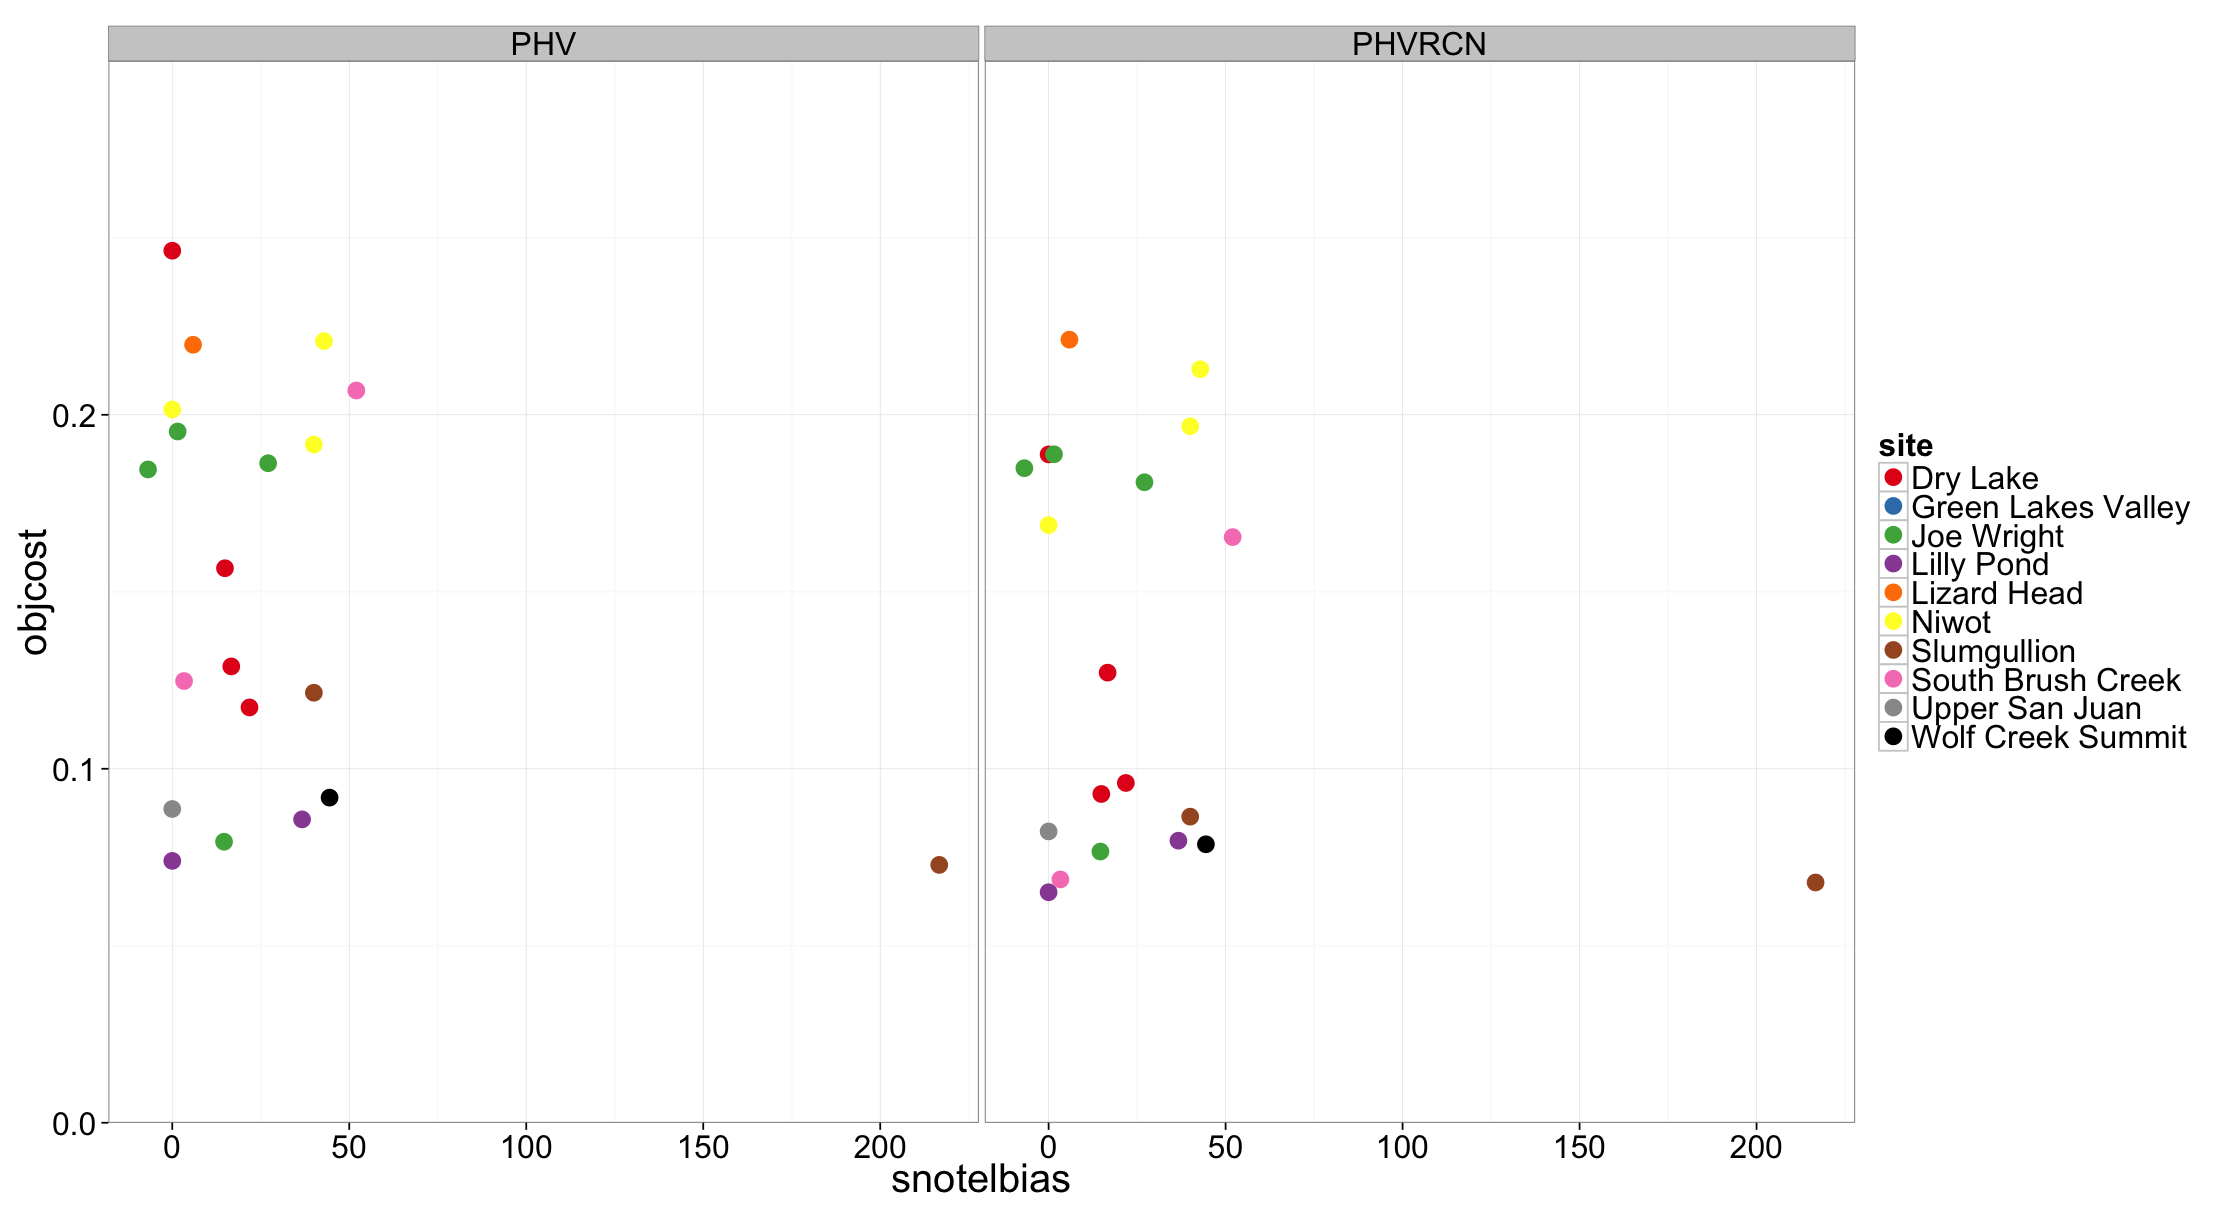

In [68]:
##plot error vs bias
options(repr.plot.width = 18.6, repr.plot.height = 10.1, jupyter.plot_mimetypes = 'image/png')
mypal=c(brewer.pal(9,'Set1'),'#000000')
ggplot(sweerror)+
    geom_point(aes(snotelbias,objcost,colour=site),size=5)+
    scale_colour_manual(values=mypal,drop=TRUE)+
    coord_fixed(ratio=1000,ylim=c(0,0.3))+
    facet_wrap(~source)+
    theme_bw(base_size=24)